# NSWの傾向スコアマッチングとIPW

In [2]:
from pathlib import Path
import pandas as pd
from dfply import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [4]:
image_dir_path = Path('image')
    
if not image_dir_path.exists():
    image_dir_path.mkdir(parents=True)

## 関数定義

In [5]:
def plot_treat_in_target(target_data, y_name, z_name, category_names, numeric_names, n_threshold=1000, image_base_file_path=None):
    
    target_data1 = target_data.loc[target_data[z_name] == 1, :].copy()
    target_data0 = target_data.loc[target_data[z_name] == 0, :].copy()
    if len(target_data1) > n_threshold:
        target_data1 = target_data1 >> sample(n_threshold)
    if len(target_data0) > n_threshold:
        target_data0 = target_data0 >> sample(n_threshold)
        
    target_data = target_data1 >> bind_rows(target_data0)
    

    # 被説明変数と介入変数のグラフ化
    sns.swarmplot(
        x=z_name, 
        y=y_name, 
        data=target_data
    )
    
    if image_base_file_path:
        plt.tight_layout()
        plt.savefig(image_base_file_path.__str__()+'_y_z.png')
     
    # 被説明変数と連続変数のグラフ化
    if len(numeric_names) > 0:

        plot_data = target_data >> select(numeric_names + [y_name, z_name])
        plot_data = plot_data.set_index([y_name, z_name])
        plot_data = plot_data.stack()
        plot_data = plot_data.reset_index(drop=False)
        plot_data.columns = [y_name, z_name, 'colname', 'value']


        kws = {'scatter_kws':{'alpha':'0.2'}}
        g = sns.FacetGrid(plot_data, col='colname', hue=z_name, col_wrap=4, sharex=False, height=5)
        g.map(sns.regplot, 'value', y_name, **kws)
        g.add_legend()
        g.set_axis_labels("", "")
        g.set_titles(size=15)
        
        if image_base_file_path:
            
            plt.tight_layout()
            plt.savefig(image_base_file_path.__str__()+'_y_z_numeric.png')

    # 被説明変数とカテゴリ変数のグラフ化
    if len(category_names) > 0:
        plot_data = target_data >> select(category_names + [y_name, z_name])
        plot_data = plot_data.set_index([y_name, z_name])
        plot_data = plot_data.stack()
        plot_data = plot_data.reset_index(drop=False)
        plot_data.columns = [y_name, z_name, 'colname', 'value']

        g = sns.catplot(
            x=z_name,
            y=y_name,
            hue='value',
            col='colname',
            kind='violin',
            data=plot_data,  
            col_wrap=4, 
            sharex=False,
            height=5,
            dodge=True
        )
        g.add_legend()
        g.set_titles(size=15)
        
        if image_base_file_path:
            plt.tight_layout()
            plt.savefig(image_base_file_path.__str__()+'_y_z_category.png')
        

In [6]:
def plot_corr(target_data, image_file_path=None):
    
    plot_data = target_data
    plot_data = plot_data.corr()
    plot_data = plot_data * 100
    g = sns.clustermap(plot_data, annot=True, fmt='1.0f', row_cluster=False, cmap='Blues')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 15)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 15)
    
    if image_file_path:
        plt.tight_layout()
        plt.savefig(image_file_path.__str__())

In [7]:
def make_ps_score_data(X_data, z_data):

    model = LogisticRegression(
        penalty='l1', 
        max_iter=10000,
        solver='liblinear',
        random_state=42
    )
    model.fit(X_data, z_data)

    ps_score_data = pd.DataFrame({
        'z': z_data, 
        'ps_score': model.predict_proba(X_data)[:, 1]
    })
    return ps_score_data

In [44]:
def plot_smd_data(adjust_smd_data, unadjust_smd_data, covariate_balance_threshold):
    
    smd_data = adjust_smd_data >> mutate(
        type='Adjusted'
    ) >> bind_rows(
        unadjust_smd_data >> mutate(
            type='Unadjusted'
        )
    )

    plot_data = smd_data >> arrange(X.colname, ascending=False)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='smd',
        y='colname',
        hue='type',
        data=plot_data
    )

    plot_data = plot_data >> distinct(X.colname) >> mutate(
        threshold=covariate_balance_threshold
    )
    plt.plot(
        plot_data['threshold'].tolist(),
        plot_data['colname'].tolist(),
        linestyle='dashdot',
        linewidth=1.2,
        color='grey'
    )
    plt.xlabel('Standard Mean Differences')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.xlim(0, 3)
    plt.tight_layout()

In [9]:
def calc_smd_data_matching(target_data):
    
    smd_data = target_data >> group_by(X.z, X.colname) >> summarise(
        n=X.value.count(),
        value_mean=X.value.mean(),
        value_std=X.value.std()
    ) >> mutate(
        std_2_n=(X.n-1)*X.value_std*X.value_std
    )
    
    smd_data = smd_data >> group_by(X.colname) >> summarise(
        mean_diff=X.value_mean.diff().values[1]
    ) >> mutate(
        mean_diff=X.mean_diff.abs()
    ) >> left_join(
        smd_data >> group_by(X.colname) >> summarise(
            s=X.std_2_n.sum()/(X.n.sum() - 2)
        ) >> mutate(
            s=X.s.apply(lambda x: np.sqrt(x))
        ), by='colname'
    ) >> mutate(
        smd=X.mean_diff/X.s
    )
    smd_data.fillna(0, inplace=True)
    
    return smd_data

In [10]:
def plot_covariate_balance_matching(target_data, matched_ps_data, z_name, covariate_balance_threshold=0.1):
    
    adjust_data = target_data.rename(columns={z_name : 'z'}).copy()
    adjust_data['index_all'] = adjust_data.index
    adjust_data = adjust_data >> rename(
        index_treatment=X.index_all
    ) >> semi_join(
        matched_ps_data, by='index_treatment'
    ) >> select(~X.index_treatment) >> bind_rows(
        adjust_data >> rename(
            index_control=X.index_all
        ) >> semi_join(
            matched_ps_data, by='index_control'
        ) >> select(~X.index_control)
    ) >> select(['z'] + x_names)

    adjust_data = adjust_data.set_index('z')
    adjust_data = adjust_data.stack()
    adjust_data = adjust_data.reset_index(drop=False)
    adjust_data.columns = ['z', 'colname', 'value']

    unadjust_data = target_data.rename(columns={z_name : 'z'}).copy()
    unadjust_data = unadjust_data >> select(['z'] + x_names)

    unadjust_data = unadjust_data.set_index('z')
    unadjust_data = unadjust_data.stack()
    unadjust_data = unadjust_data.reset_index(drop=False)
    unadjust_data.columns = ['z', 'colname', 'value']

    adjust_smd_data = calc_smd_data_matching(adjust_data)
    unadjust_smd_data = calc_smd_data_matching(unadjust_data)

    plot_smd_data(
        adjust_smd_data=adjust_smd_data,
        unadjust_smd_data=unadjust_smd_data,
        covariate_balance_threshold=covariate_balance_threshold
    )

In [11]:
def get_matched_propensity_score(target_data, y_name, z_name, x_names, threshold=0.2, 
                                 flag_covariate_barance=True, covariate_balance_threshold=0.1):
    
    
    ps_score_data = make_ps_score_data(
        X_data = target_data >> select(x_names),
        z_data = target_data[z_name]
    )
    ps_score_data['index_all'] = target_data.index
    ps_score_data['y'] = target_data[y_name]
    

    treatment_data = ps_score_data >> filter_by(X.z == 1) >> rename(
        index_treatment=X.index_all
    )
    treatment_data.reset_index(inplace=True, drop=True)
    control_data = ps_score_data >> filter_by(X.z == 0) >> rename(
        index_control=X.index_all
    )
    control_data.reset_index(inplace=True, drop=True)


    match_index_data = pd.DataFrame()
    treatment_data_tmp = treatment_data.copy()
    control_data_tmp = control_data.copy()


    while len(treatment_data_tmp) > 0 and len(control_data_tmp) > 0:

        neigh = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        neigh.fit(control_data_tmp['ps_score'].values.reshape(-1, 1))
        distances, indices = neigh.kneighbors(treatment_data_tmp['ps_score'].values.reshape(-1, 1))

        distance_data = pd.DataFrame({
            'distance': distances.reshape(-1), 
            'index_treatment': treatment_data_tmp['index_treatment'].values,
            'index_control' : control_data_tmp['index_control'][indices.reshape(-1)]
        }) >> filter_by(X.distance <= threshold) >> arrange(X.distance) >> distinct(X.index_control)

        if len(distance_data) == 0:
            break

        match_index_data = match_index_data >> bind_rows(
            distance_data >> select(X.index_treatment, X.index_control, X.distance)
        )

        treatment_data_tmp = treatment_data_tmp >> anti_join(distance_data, by='index_treatment')
        control_data_tmp = control_data_tmp >> anti_join(distance_data, by='index_control')

        treatment_data_tmp.reset_index(inplace=True, drop=True)
        control_data_tmp.reset_index(inplace=True, drop=True)

        
    match_index_data = match_index_data >> arrange(X.index_treatment)
    match_index_data.reset_index(inplace=True, drop=True)

    matched_ps_data = match_index_data >> left_join(
        ps_score_data >> rename(
            y_treatment=X.y,
            ps_score_treatment=X.ps_score,
            index_treatment=X.index_all
        ) >> select(
            X.index_treatment, X.y_treatment, X.ps_score_treatment
        ), by='index_treatment' 
    ) >> left_join(
        ps_score_data >> rename(
            y_control=X.y,
            ps_score_control=X.ps_score,
            index_control=X.index_all
        ) >> select(
            X.index_control, X.y_control, X.ps_score_control
        ), by='index_control' 
    ) >> mutate(y_diff=X.y_treatment-X.y_control)
    
    
    target_data_lr = matched_ps_data >> select(X.y_treatment) >> mutate(z=1) >> rename(
        y=X.y_treatment
    ) >> bind_rows(
        matched_ps_data >> select(X.y_control) >> mutate(z=0) >> rename(
            y=X.y_control
        )
    )
    X_data = target_data_lr >> select('z')
    X_data = sm.add_constant(X_data)
    
    model = sm.OLS(target_data_lr['y'], X_data)

    results = model.fit()
    results = results.summary()
    
    if flag_covariate_barance:
        plot_covariate_balance_matching(
            target_data=target_data.copy(),
            matched_ps_data=matched_ps_data.copy(),
            z_name=z_name,
            covariate_balance_threshold=covariate_balance_threshold
        )
    
    return results, matched_ps_data

In [12]:
def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return np.sqrt(variance)

In [13]:
def calc_smd_data_ipw(target_data):
    
    smd_data = target_data.groupby(['z', 'colname']).apply(
        lambda x: np.average(x['value'], weights=x['w'])
    )
    smd_data = smd_data.reset_index(drop=False)
    smd_data.columns = ['z', 'colname', 'value_mean']
    
    smd_data_std = target_data.groupby(['z', 'colname']).apply(
        lambda x: weighted_std(x['value'], weights=x['w'])
    )
    smd_data_std = smd_data_std.reset_index(drop=False)
    smd_data_std.columns = ['z', 'colname', 'value_std']

    smd_data = smd_data >> left_join(
        smd_data_std, by=['z', 'colname']
    ) >> left_join(
        target_data >> group_by(X.z) >> summarise(n=X.z.count())
    ) >> mutate(
        std_2_n=(X.n-1)*X.value_std*X.value_std
    )

    smd_data = smd_data >> group_by(X.colname) >> summarise(
        mean_diff=X.value_mean.diff().values[1]
    ) >> mutate(
        mean_diff=X.mean_diff.abs()
    ) >> left_join(
        smd_data >> group_by(X.colname) >> summarise(
            s=X.std_2_n.sum()/(X.n.sum() - 2)
        ) >> mutate(
            s=X.s.apply(lambda x: np.sqrt(x))
        ), by='colname'
    ) >> mutate(
        smd=X.mean_diff/X.s
    )
    smd_data.fillna(0, inplace=True)
    
    return smd_data

In [14]:
def plot_covariate_balance_ipw(target_data, ipw_data, z_name, x_names, covariate_balance_threshold=0.1):
    
    adjust_data = target_data >> select(
        ['index_all'] + x_names
    ) >> inner_join(
        ipw_data >> select(X.index_all, X.z, X.w), by='index_all'
    ) >> select(~X.index_all)
    adjust_data = adjust_data.set_index(['z', 'w'])
    adjust_data = adjust_data.stack()
    adjust_data = adjust_data.reset_index(drop=False)
    adjust_data.columns = ['z', 'w', 'colname', 'value']

    unadjust_data = target_data.rename(columns={z_name:'z'})
    unadjust_data = unadjust_data >> select(
        ['z'] + x_names
    ) >> mutate(w=1)
    unadjust_data = unadjust_data.set_index(['z', 'w'])
    unadjust_data = unadjust_data.stack()
    unadjust_data = unadjust_data.reset_index(drop=False)
    unadjust_data.columns = ['z', 'w', 'colname', 'value']

    adjust_smd_data = calc_smd_data_ipw(adjust_data)
    unadjust_smd_data = calc_smd_data_ipw(unadjust_data)
    
    plot_smd_data(
        adjust_smd_data=adjust_smd_data,
        unadjust_smd_data=unadjust_smd_data,
        covariate_balance_threshold=covariate_balance_threshold
    )

In [39]:
def get_ipw(target_data, y_name, z_name, x_names, ps_score_min=0.1, ps_score_max=0.9,
            flag_covariate_balance=True, covariate_balance_threshold=0.1):
    
    target_data['index_all'] = target_data.index

    ps_score_data = make_ps_score_data(
        X_data = target_data >> select(x_names),
        z_data = target_data[z_name]
    )
    ps_score_data['index_all'] = target_data['index_all']

    ps_score_data = ps_score_data >> filter_by(
        X.ps_score <= ps_score_max, X.ps_score >= ps_score_min
    )
    
    ps_score_data = ps_score_data >> mutate(
        iestep1=(X.z/X.ps_score)*(len(ps_score_data)/ps_score_data['z'].sum()),
        iestep0=((1-X.z)/(1-X.ps_score))*(len(ps_score_data)/(len(ps_score_data)-ps_score_data['z'].sum()))
    ) >> mutate(
        w=X.iestep1+X.iestep0
    )
    
    ipw_data = target_data >> select(
        ['index_all', y_name] + x_names
    ) >> inner_join(
        ps_score_data, by='index_all'
    )
    ipw_data.reset_index(inplace=True, drop=True)
    
    
    y_data = ipw_data[y_name].values
    z_data = ipw_data >> select(X.z) 
    z_data = sm.add_constant(z_data)

    model = sm.WLS(y_data, z_data, weights=ipw_data['w'].values)
    results = model.fit()
    results = results.summary()
    
    
    y1 = ipw_data >> filter_by(X.z == 1)
    y1_mean = y1[y_name].mean()
    y0 = ipw_data >> filter_by(X.z == 0)
    y0_mean = y0[y_name].mean()

    ATT = y1_mean - np.sum((
        (1-ipw_data['z'])*ipw_data['ps_score']*ipw_data[y_name])/(1-ipw_data['ps_score'])
    )/np.sum(
        ((1-ipw_data['z'])*ipw_data['ps_score'])/(1-ipw_data['ps_score'])
    )

    ATU = np.sum(
        (ipw_data['z']*(1-ipw_data['ps_score'])*ipw_data[y_name])/ipw_data['ps_score']
    )/np.sum(
        (ipw_data['z']*(1-ipw_data['ps_score']))/ipw_data['ps_score']
    ) - y0_mean

    results_other = pd.DataFrame({
        'estimate' : ['ATT', 'ATU'],
        'value' : [ATT, ATU]
    })
    
    if flag_covariate_balance:
        plot_covariate_balance_ipw(
            target_data=target_data,
            ipw_data=ipw_data,
            z_name=z_name,
            x_names=x_names,
            covariate_balance_threshold=covariate_balance_threshold
        )

    return results, ipw_data, results_other

## データの取得

In [16]:
nswdw_data = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
cps1_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')

In [17]:
nswdw_data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [18]:
cps1_nsw_data = nswdw_data >> filter_by(
    X.treat == 1
) >> bind_rows(
    cps1_data
)
cps1_nsw_data.reset_index(inplace=True, drop=True)

## データの理解

### 共変量の各々との関係

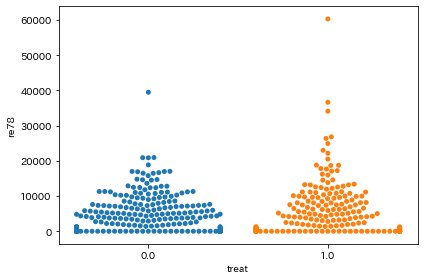

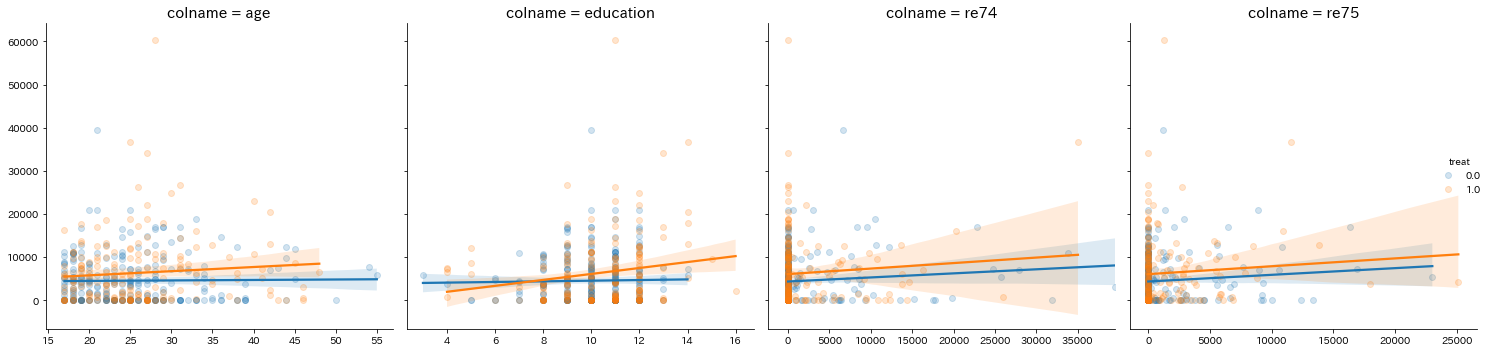

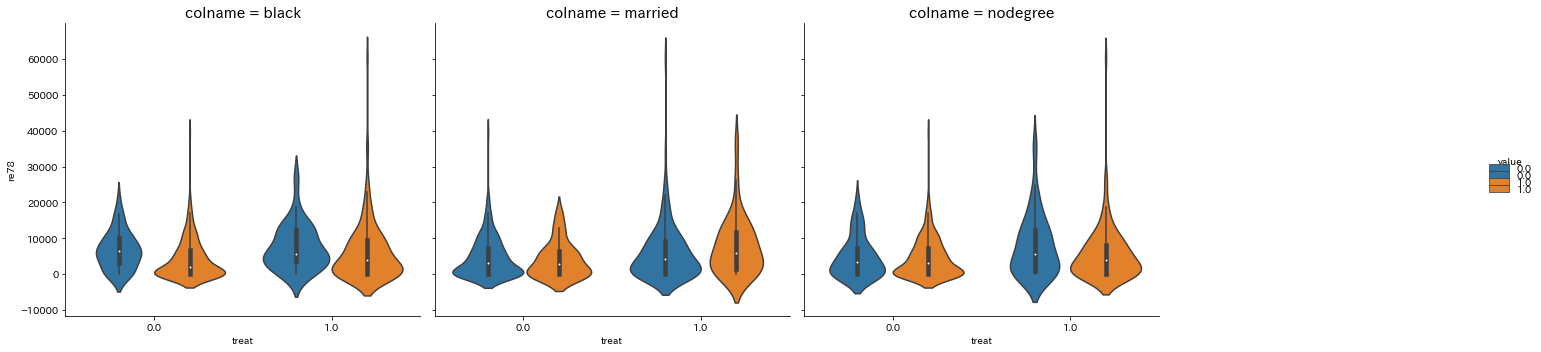

In [19]:
y_name = 're78'
z_name = 'treat'
category_names = ['black', 'married', 'nodegree']
numeric_names = ['age', 'education', 're74', 're75']


plot_treat_in_target(
    target_data=nswdw_data.copy(),
    y_name=y_name,
    z_name=z_name,
    category_names = category_names,
    numeric_names = numeric_names,
    n_threshold=1000,
    image_base_file_path=image_dir_path.joinpath('nsw')
)

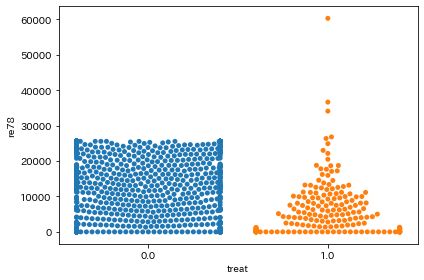

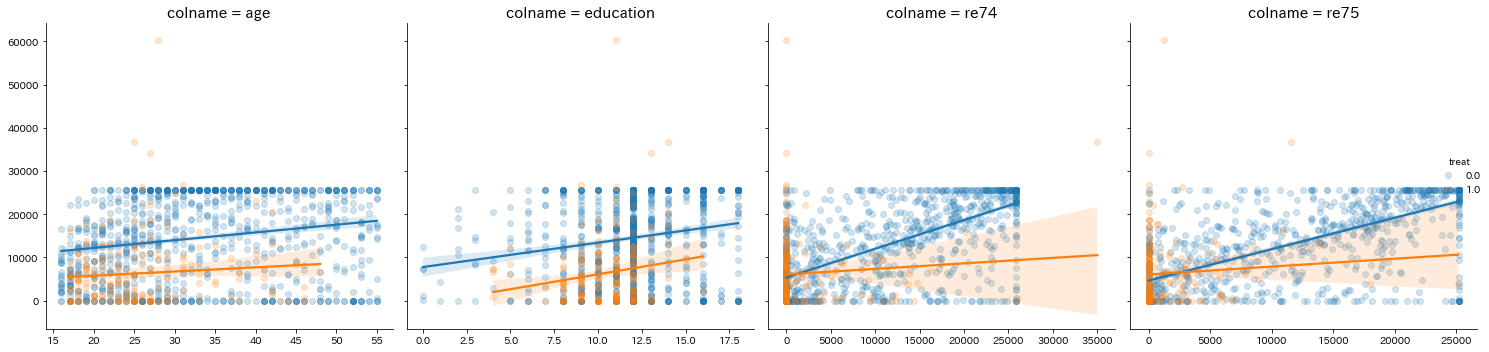

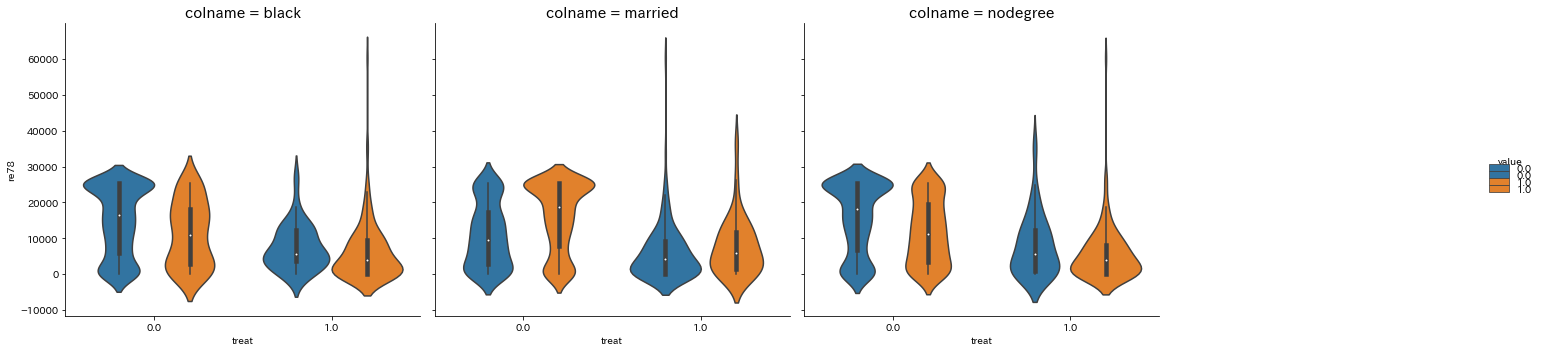

In [20]:
plot_treat_in_target(
    target_data=cps1_nsw_data.copy(),
    y_name=y_name,
    z_name=z_name,
    category_names = category_names,
    numeric_names = numeric_names,
    n_threshold=1000,
    image_base_file_path=image_dir_path.joinpath('cps1')
)

### 相関分析

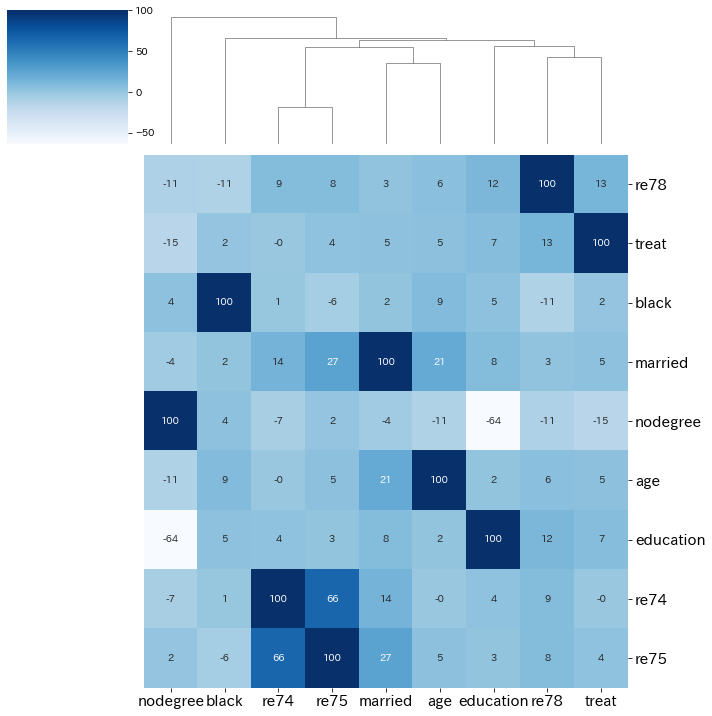

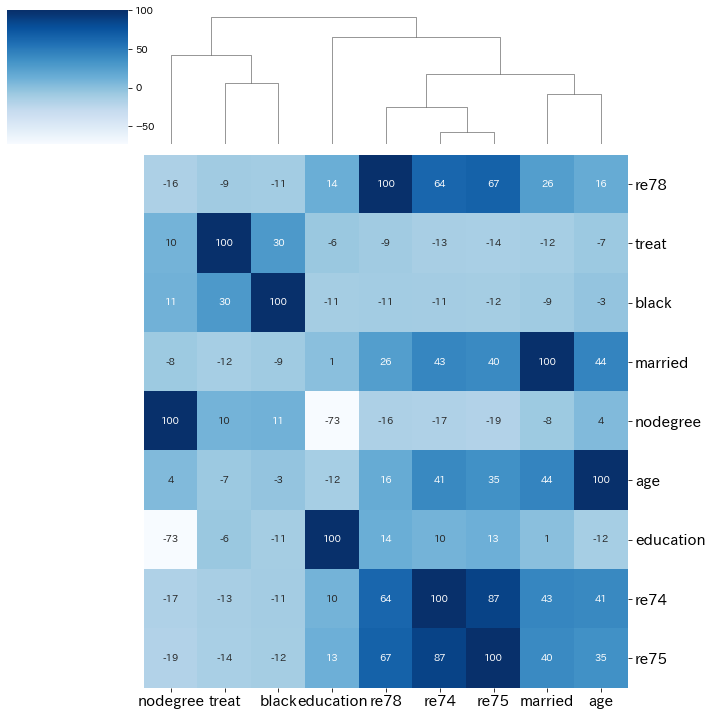

In [21]:
plot_corr(
    nswdw_data >> select([y_name, z_name] + category_names + numeric_names),
    image_file_path=image_dir_path.joinpath('nsw_corr.png')
)

plot_corr(
    cps1_nsw_data >> select([y_name, z_name] + category_names + numeric_names),
    image_file_path=image_dir_path.joinpath('cps_corr.png')
)

## 因果推定

### 単純推定

In [22]:
result_nsw = nswdw_data >> group_by(X.treat) >> summarise(
    n=X.treat.count(),
    re78_mean=X.re78.mean().round().astype(int),
    re78_median=X.re78.median().round().astype(int),
    re78_std=X.re78.std().round().astype(int)
) >> mutate(treat=X.treat.astype(int))
result_nsw

,treat,n,re78_mean,re78_median,re78_std
0,0,260,4555,3139,5484
1,1,185,6349,4232,7867


In [23]:
result_cps = cps1_nsw_data >> group_by(X.treat) >> summarise(
    n=X.treat.count(),
    re78_mean=X.re78.mean().round().astype(int),
    re78_median=X.re78.median().round().astype(int),
    re78_std=X.re78.std().round().astype(int)
) >> mutate(treat=X.treat.astype(int))
result_cps

,treat,n,re78_mean,re78_median,re78_std
0,0,15992,14847,16422,9647
1,1,185,6349,4232,7867


### 線形回帰による因果推定

In [24]:
y_name = 're78'
z_name = 'treat'
x_names = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']

In [25]:
target_data = nswdw_data >> select([y_name, z_name] + x_names)

model = sm.OLS(target_data[y_name], target_data.drop(columns=y_name))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   re78   R-squared (uncentered):                   0.424
Model:                            OLS   Adj. R-squared (uncentered):              0.412
Method:                 Least Squares   F-statistic:                              35.62
Date:                Wed, 22 Jul 2020   Prob (F-statistic):                    4.51e-47
Time:                        17:29:26   Log-Likelihood:                         -4534.2
No. Observations:                 445   AIC:                                      9086.
Df Residuals:                     436   BIC:                                      9123.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treat       1698.3170    630.972      2.692      0.007     458.193    2938.441
age           59.7197     41.093      1.453      0.147     -21.046     140.486
education    441.4534    114.275      3.863      0.000     216.855     666.052
black      -2088.4810   1127.214     -1.853      0.065   -4303.929     126.967
hispanic     273.2174   1475.048      0.185      0.853   -2625.871    3172.305
married     -162.1321    873.006     -0.186      0.853   -1877.955    1553.691
nodegree      89.9847    728.406      0.124      0.902   -1341.639    1521.608
re74           0.0840      0.077      1.093      0.275      -0.067       0.235
re75           0.0506      0.135      0.375      0.708      -0.215       0.316
==============================================================================
Omnibus:                      283.309   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3713.376
Skew:                           2.531   Prob(JB):                         0.00
Kurtosis:                      16.216   Cond. No.                     3.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
target_data = cps1_nsw_data >> select([y_name, z_name] + x_names)

model = sm.OLS(target_data[y_name], target_data.drop(columns=y_name))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   re78   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              9487.
Date:                Wed, 22 Jul 2020   Prob (F-statistic):                        0.00
Time:                        17:29:26   Log-Likelihood:                     -1.6627e+05
No. Observations:               16177   AIC:                                  3.326e+05
Df Residuals:                   16168   BIC:                                  3.326e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treat        770.0665    550.396      1.399      0.162    -308.770    1848.903
age          -72.1373      5.437    -13.268      0.000     -82.795     -61.480
education    496.3644     11.756     42.221      0.000     473.321     519.408
black       -538.4208    212.637     -2.532      0.011    -955.214    -121.628
hispanic     206.6039    217.262      0.951      0.342    -219.254     632.462
married      162.3382    142.964      1.136      0.256    -117.887     442.563
nodegree    1956.6469    128.777     15.194      0.000    1704.231    2209.063
re74           0.2898      0.012     23.860      0.000       0.266       0.314
re75           0.4727      0.012     38.663      0.000       0.449       0.497
==============================================================================
Omnibus:                     1561.613   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3102.244
Skew:                          -0.638   Prob(JB):                         0.00
Kurtosis:                       4.724   Cond. No.                     2.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 傾向スコアの算出

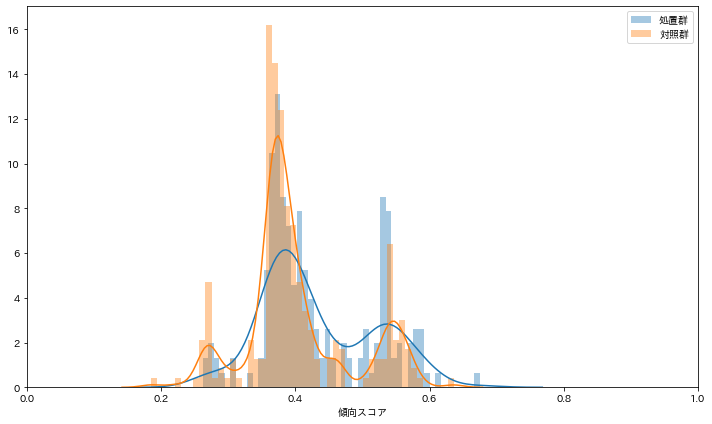

In [27]:
z_name = 'treat'
X_names = list(filter(lambda x: x != y_name and x != z_name, target_data.columns))

plt.figure(figsize=(10, 6))
ps_score_data_nsw = make_ps_score_data(
    X_data=nswdw_data >> select(X_names),
    z_data=nswdw_data[z_name]
)
sns.distplot(ps_score_data_nsw.loc[ps_score_data_nsw['z'] == 1, 'ps_score'], label='処置群', bins=50)
sns.distplot(ps_score_data_nsw.loc[ps_score_data_nsw['z'] == 0, 'ps_score'], label='対照群', bins=50)
plt.legend()
plt.xlabel('傾向スコア')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(image_dir_path.joinpath('ps_score_distibution_nsw.png'))

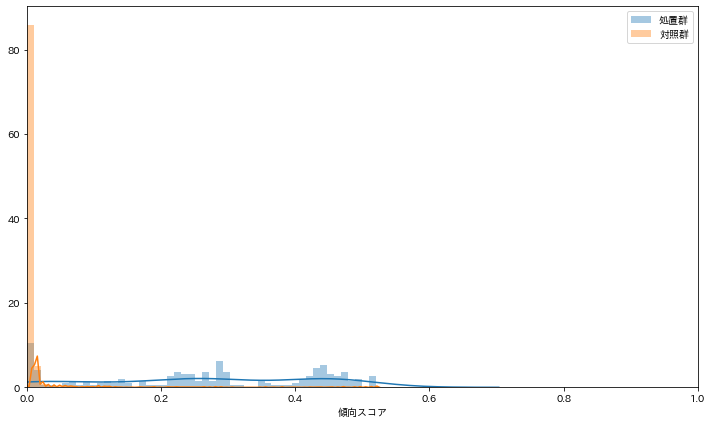

In [28]:
plt.figure(figsize=(10, 6))
ps_score_data_cps = make_ps_score_data(
    X_data=cps1_nsw_data >> select(X_names),
    z_data=cps1_nsw_data[z_name]
)
sns.distplot(ps_score_data_cps.loc[ps_score_data_cps['z'] == 1, 'ps_score'], label='処置群', bins=50)
sns.distplot(ps_score_data_cps.loc[ps_score_data_cps['z'] == 0, 'ps_score'], label='対照群', bins=50)
plt.legend()
plt.xlabel('傾向スコア')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(image_dir_path.joinpath('ps_score_distibution_cps.png'))

### 傾向スコアマッチング

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.021
Date:                Wed, 22 Jul 2020   Prob (F-statistic):             0.0146
Time:                        17:29:28   Log-Likelihood:                -3759.3
No. Observations:                 368   AIC:                             7523.
Df Residuals:                     366   BIC:                             7530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4619.0694    488.772      9.450      0.000    3657.916    5580.222
z           1696.1525    691.227      2.454      0.015     336.877    3055.428
==============================================================================
Omnibus:                      237.830   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2994.063
Skew:                           2.530   Prob(JB):                         0.00
Kurtosis:                      16.026   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

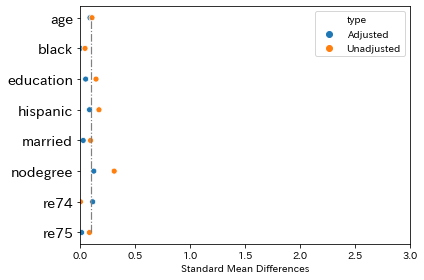

In [29]:
target_data = nswdw_data >> select(~X.data_id)

y_name = 're78'
z_name = 'treat'
x_names = list(filter(lambda x: x != y_name and x != z_name, target_data.columns))

results, matched_ps_data = get_matched_propensity_score(
    target_data=target_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    threshold=0.2,
    flag_covariate_barance=True,
    covariate_balance_threshold=0.1
)

results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.899
Date:                Wed, 22 Jul 2020   Prob (F-statistic):             0.0156
Time:                        17:29:29   Log-Likelihood:                -3790.2
No. Observations:                 370   AIC:                             7584.
Df Residuals:                     368   BIC:                             7592.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4626.9935    501.396      9.228      0.000    3641.034    5612.953
z           1722.1500    709.080      2.429      0.016     327.792    3116.508
==============================================================================
Omnibus:                      229.707   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2476.166
Skew:                           2.459   Prob(JB):                         0.00
Kurtosis:                      14.681   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

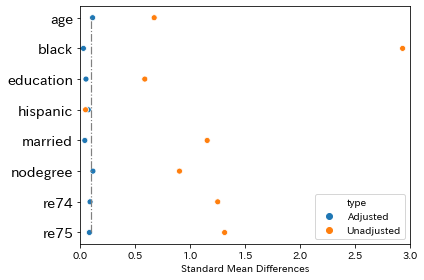

In [30]:
target_data = cps1_nsw_data >> select(~X.data_id)

y_name = 're78'
z_name = 'treat'
x_names = list(filter(lambda x: x != y_name and x != z_name, target_data.columns))

results, matched_ps_data = get_matched_propensity_score(
    target_data=target_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    threshold=0.2,
    flag_covariate_barance=True,
    covariate_balance_threshold=0.1
)

results

### IPWによる推定

  estimate        value
0      ATT  1827.592182
1      ATU  1468.136762


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.938
Date:                Wed, 22 Jul 2020   Prob (F-statistic):             0.0152
Time:                        17:29:29   Log-Likelihood:                -4579.9
No. Observations:                 445   AIC:                             9164.
Df Residuals:                     443   BIC:                             9172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4541.0514    507.554      8.947      0.000    3543.539    5538.564
z           1617.9723    663.973      2.437      0.015     313.044    2922.901
==============================================================================
Omnibus:                      345.129   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8192.447
Skew:                           3.096   Prob(JB):                         0.00
Kurtosis:                      23.087   Cond. No.                         2.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

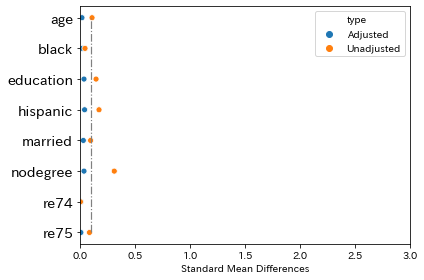

In [31]:
results, ipw_data, results_other = get_ipw(
    target_data=nswdw_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    ps_score_max=0.9,
    ps_score_min=0.1,
    flag_covariate_balance=True, 
    covariate_balance_threshold=0.1
)
print(results_other)
results

  estimate        value
0      ATT  1558.094804
1      ATU  1544.328747


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.551
Date:                Wed, 22 Jul 2020   Prob (F-statistic):             0.0334
Time:                        17:29:30   Log-Likelihood:                -5331.0
No. Observations:                 506   AIC:                         1.067e+04
Df Residuals:                     504   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4523.4550    615.992      7.343      0.000    3313.226    5733.684
z           1548.2722    725.765      2.133      0.033     122.374    2974.170
==============================================================================
Omnibus:                      455.331   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18596.832
Skew:                           3.732   Prob(JB):                         0.00
Kurtosis:                      31.746   Cond. No.                         3.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

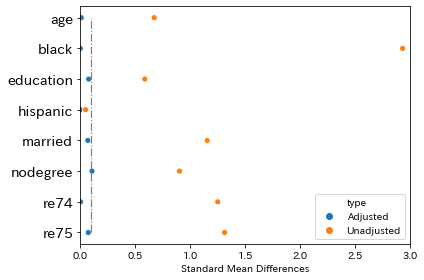

In [32]:
results, ipw_data, results_other = get_ipw(
    target_data=cps1_nsw_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    ps_score_max=0.9,
    ps_score_min=0.1,
    flag_covariate_balance=True, 
    covariate_balance_threshold=0.1
)
print(results_other)
results

In [33]:
game_data = pd.read_csv('https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv')

### 効果検証

In [34]:
Y_data = game_data['gamesecond'].values
Z_data = game_data['cm_dummy'].values
X_data = game_data >> select(
    X.TVwatch_day, X.age, X.sex, X.marry_dummy, X.child_dummy,
    X.inc, X.pmoney, X.area_kanto, X.area_tokai, X.area_keihanshin, 
    X.job_dummy1, X.job_dummy2, X.job_dummy3, X.job_dummy4,
    X.job_dummy5, X.job_dummy6, X.job_dummy7, X.fam_str_dummy1, 
    X.fam_str_dummy2, X.fam_str_dummy3, X.fam_str_dummy4
)
x_names = X_data.columns.tolist()
X_data = X_data.values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.621
Date:                Wed, 22 Jul 2020   Prob (F-statistic):              0.203
Time:                        17:35:44   Log-Likelihood:                -64319.
No. Observations:                5852   AIC:                         1.286e+05
Df Residuals:                    5850   BIC:                         1.287e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2775.3472    265.459     10.455      0.000    2254.950    3295.744
z           -478.0031    375.415     -1.273      0.203   -1213.956     257.950
==============================================================================
Omnibus:                     7508.702   Durbin-Watson:                   1.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           937970.013
Skew:                           7.311   Prob(JB):                         0.00
Kurtosis:                      63.274   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

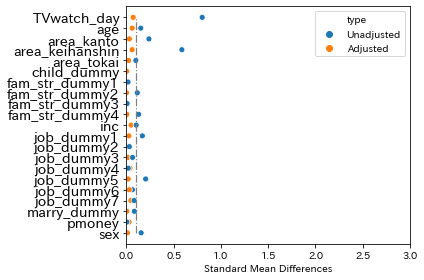

In [40]:
target_data = game_data

y_name = 'gamesecond'
z_name = 'cm_dummy'
x_names = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy',
    'inc', 'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin', 
    'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4',
    'job_dummy5', 'job_dummy6', 'job_dummy7', 'fam_str_dummy1', 
    'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]

results, matched_ps_data = get_matched_propensity_score(
    target_data=target_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    threshold=0.2,
    flag_covariate_barance=True,
    covariate_balance_threshold=0.1
)

results

  estimate        value
0      ATT  -812.903593
1      ATU -1166.099561


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.893
Date:                Wed, 22 Jul 2020   Prob (F-statistic):            0.00497
Time:                        17:38:12   Log-Likelihood:                -93926.
No. Observations:                8399   AIC:                         1.879e+05
Df Residuals:                    8397   BIC:                         1.879e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3129.2714    274.042     11.419      0.000    2592.082    3666.461
z          -1017.9326    362.330     -2.809      0.005   -1728.189    -307.676
==============================================================================
Omnibus:                    12852.154   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4992339.512
Skew:                           9.759   Prob(JB):                         0.00
Kurtosis:                     120.833   Cond. No.                         2.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

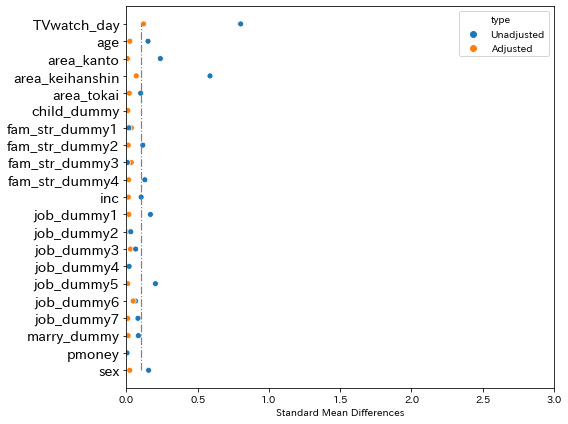

In [45]:
results, ipw_data, results_other = get_ipw(
    target_data=game_data.copy(),
    y_name=y_name,
    z_name=z_name,
    x_names=x_names,
    ps_score_max=0.9,
    ps_score_min=0.1,
    flag_covariate_balance=True, 
    covariate_balance_threshold=0.1
)
print(results_other)
results